# Lambda Classification via Normalizing flows
## Created by Rowan Kelleher, using Matthew McEneaney's Graph Neural Network Implementation

#### Imports
Below are the library imports I use for the notebook

In [39]:
#normflows implements normalizing flows with pytorch neural networks
import normflows as nf
from normflows import flows

import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

#dgl is used for GNN implementation
import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

#tqdm progress bar for monitoring training/testing time length
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#fit functions and optimization
import scipy.optimize as opt
from scipy.stats import crystalball

#roc-curve calculations
from sklearn.metrics import roc_auc_score, roc_curve

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


**Here we have custom functions defines either in models.py, utils.py (GNN) or NF_utils.py (NF)**

utils.py contains classes and functions implementing GNNs for Lambda signal extraction; models.py contains GNN models

NF_Utils.py contains several classes and functions that provide an implementation of the normflows networks for latent space domain adaptation (training, transforming, data structures, etc)


In [40]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info, roc_curve
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified,get_classification_probs

**For classifiying lambdas, we use graph representations that have been pre-processed by Matthew using his GNN implementation at https://github.com/mfmceneaney/Lambda-GNNs**

These graphs are loaded via the *GraphDataSet* constructor and the *load()* function

The GNN is created with the *GIN* constructor and loaded with weights pre-trained using the *Lambda-GNNs* repo and the *load_state_dict()* function

In [3]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

#Number of graphs in each
# DATA_max_events = 149090
DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [4]:
MCgraph_dataset = GraphDataset(prefix+MCdataset)
DATAgraph_dataset = GraphDataset(prefix+DATAdataset)
MCgraph_dataset.load()
DATAgraph_dataset.load()

**Now we define the number of samples per batch for our NF training and create *Latent_data* data structures for training the NF models**

The create_latent_data function extracts the latent representation of the data using the GNN

In [5]:
num_samples = 100

training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = num_samples, max_events = DATA_max_events,  given_dataset = True, in_dataset = DATAgraph_dataset)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = num_samples, max_events = MC_max_events,  given_dataset = True, in_dataset = MCgraph_dataset)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = num_samples, max_events = DATA_max_events, sidebands =False, given_dataset = True, in_dataset = DATAgraph_dataset)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events,  given_dataset = True, in_dataset = MCgraph_dataset)

val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "val",num_samples = num_samples, max_events = DATA_max_events,  given_dataset = True, in_dataset = DATAgraph_dataset)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events,  given_dataset = True, in_dataset = MCgraph_dataset)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



Now we create the two NF models (Data and MC) using the *nf.NormalizingFlow()* constructor

The *get_masked_affine* function that returns a list of *nf.flows.MaskedAffineFlow* from the *normflows* library which are the network layers

We define the number of layers in the model as well as the base distribution used in training NFs

In [41]:
# SETTING UP DATA MODEL
num_layers = 52

masked_affine_flows_train_DATA = get_masked_affine(num_layers)
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)

In [6]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(num_layers)
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

Now we train the MC model using the *train* function from *NF_utils.py* which returns training stats for easy plotting
(num_epochs defines how many epochs to train, compact_num defines the number of training iterations to average over when saving loss data for plotting)

The *plot_loss* function displays the loss curve for estimating performance, and prints the lowest lost achieved

100%|██████████| 1128/1128 [02:39<00:00,  7.05it/s]


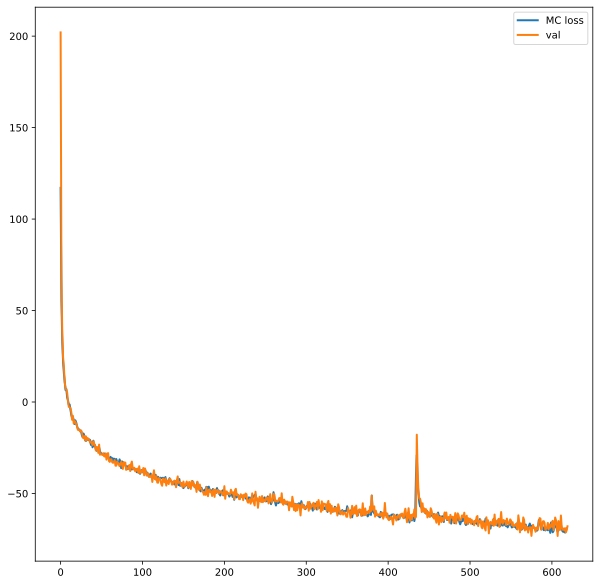

Lowest Loss: -71.52269058227539


In [7]:
'''
TRAIN MC MODEL
'''
MC_loss_hist, MC_val_hist, full_loss_hist, MC_full_val_hist = train(training_data_MC, MC_model, val = True, val_data = val_data_MC, num_epochs = 11, compact_num = 20)
plot_loss(MC_loss_hist, label = "MC loss",plot_val = True, val_loss_hist = MC_val_hist)

You can save the trained model with the line below, using the *save()* method of the *nf.NormalizingFlow* class, where the only argument is the save file location

(note: save models with \*.pth file type)

In [8]:
# MC_model.save("models/MC_test.pth")

To load a previously saved model, uncomment the cell below

This cell constructs the flows and model objects, but loads the model with the saved info instead of training

In [9]:
'''
LOAD SAVED MC MODEL
'''
# masked_affine_flows_train_MC = get_masked_affine(52)
# distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
# masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
# masked_affine_model_MC.load("models/MC_test.pth")
# MC_model = masked_affine_model_MC.to(device)

'\nLOAD SAVED MC MODEL\n'

Here we can test the MC model on our testing segment of the dataset

The *test()* function from *NF_utils.py* prints the average loss across all batches tested (if this is much higher than the lowest training loss, something may have gone wrong)

In [42]:
'''
TESTING MC MODEL
'''
test(testing_data_MC, MC_model, data_type = "MC")

100%|██████████| 141/141 [00:03<00:00, 46.49it/s]

MC average loss: -67.61296844482422


The following cells do the same things as the previous 4 cells, now for DATA instead of MC

100%|██████████| 1992/1992 [04:00<00:00,  8.29it/s]


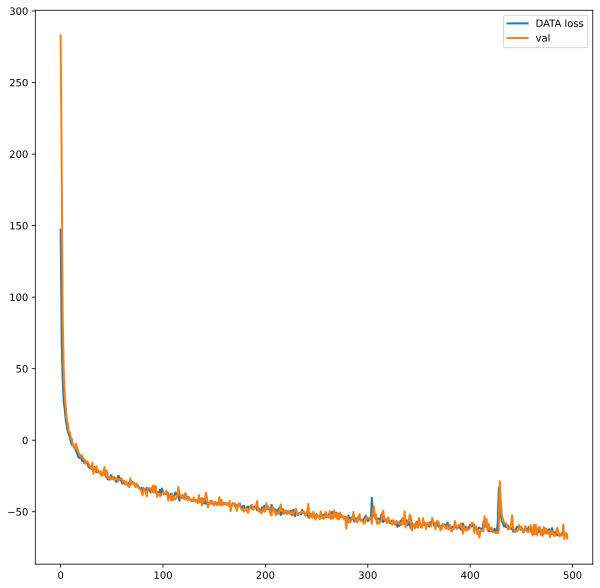

Lowest Loss: -66.69736347198486


In [43]:
'''
TRAINING DATA MODEL
'''
DATA_loss_hist, DATA_val_hist, DATA_full_loss_hist, DATA_full_val_hist = train(training_data_DATA, DATA_model, val = True, val_data = val_data_DATA, num_epochs = 5, compact_num = 20)
plot_loss(DATA_loss_hist, label = "DATA loss", plot_val = True, val_loss_hist = DATA_val_hist)

In [44]:
'''
SAVE DATA MODEL
'''
# DATA_model.save("models/DATA_test.pth")

'\nSAVE DATA MODEL\n'

In [45]:
'''
LOAD SAVED DATA MODEL
'''
# masked_affine_flows_train_DATA = get_masked_affine(52)
# distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
# masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
# masked_affine_model_DATA.load("models/DATA_test.pth")
# DATA_model = masked_affine_model_DATA.to(device)

'\nLOAD SAVED DATA MODEL\n'

In [46]:
'''
TESTING DATA MODEL
'''
test(testing_data_DATA, DATA_model, data_type = "DATA")

100%|██████████| 249/249 [00:05<00:00, 47.92it/s]

DATA average loss: -65.39450073242188


The next cell uses the trained NF models to transform data from the Latent domain to a normalized domain, and then to the MC latent domain (fullpass)

This uses the *transform()* function from *NF_Utils.py* to iteratively pass through each batch through the trained models, and stores the outputs in new *Latent_data* objects

Note: the MC data doesn't necessarily need to be transformed, only if using for something specific

In [47]:
'''
TRANSFORMING
'''

transformed_latent_DATA = transform(testing_data_DATA, DATA_model)
transformed_latent_MC = transform(testing_data_MC, MC_model)

'''training and validation datasets can be transformed as well if needed'''

transformed_latent_train_MC = transform(training_data_MC, MC_model)
transformed_latent_train_DATA = transform(training_data_DATA, DATA_model)
transformed_latent_val_MC = transform(val_data_MC, MC_model)
transformed_latent_val_DATA = transform(val_data_DATA, DATA_model)

'''transform() returns a torch.tensor object, so we use these to create new Latent_data objects that know the labels'''
transformed_latent_DATA_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
transformed_latent_DATA_obj.set_batch_size(num_samples)
transformed_latent_MC_obj = Latent_data(transformed_latent_MC,testing_data_MC.labels)
transformed_latent_MC_obj.set_batch_size(num_samples)

transformed_latent_train_DATA_obj = Latent_data(transformed_latent_train_DATA,training_data_DATA.labels)
transformed_latent_train_DATA_obj.set_batch_size(num_samples)
transformed_latent_train_MC_obj = Latent_data(transformed_latent_train_MC,training_data_MC.labels)
transformed_latent_train_MC_obj.set_batch_size(num_samples)

transformed_latent_val_DATA_obj = Latent_data(transformed_latent_val_DATA,val_data_DATA.labels)
transformed_latent_val_MC_obj = Latent_data(transformed_latent_val_MC,val_data_MC.labels)

'''pass the normalized data through "forward" direction of MC to complete full transformation'''
full_pass_DATA = transform(transformed_latent_DATA_obj, MC_model, reverse = False)
full_pass_DATA_obj = Latent_data(full_pass_DATA, testing_data_DATA.labels)
full_pass_DATA_obj.set_batch_size(num_samples)

full_pass_train_DATA = transform(transformed_latent_train_DATA_obj, MC_model, reverse = False)
full_pass_train_DATA_obj = Latent_data(full_pass_train_DATA, training_data_DATA.labels)
full_pass_train_DATA_obj.set_batch_size(num_samples)

100%|██████████| 1992/1992 [00:40<00:00, 48.98it/s]


## Prediction

Now we can predict if Lambda events are signal or background with a classification network

In [48]:
'''
CLASSIFIER CONSTRUCTION
'''

classifier = NFClassifier(num_layers = 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

100%|██████████| 1128/1128 [00:07<00:00, 145.50it/s]


Finished Training


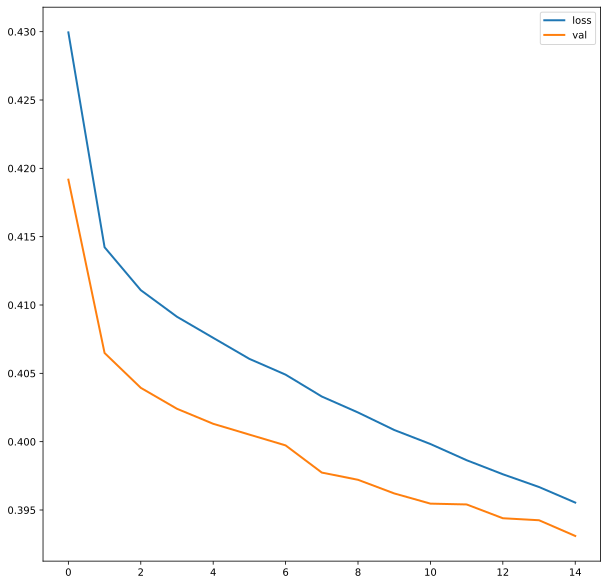

Lowest Loss: 0.3955431527042009


In [49]:
'''
PLOTTING CLASSIFIER LOSS
'''

loss_hist, val_loss_hist = train_classifier(training_data_MC, classifier, criterion, optimizer, val = True, val_data = val_data_MC, num_epochs = num_epochs_classifier)

# Can save the loss-plot with the save and save_loc optional arguments
plot_loss(loss_hist, plot_val =True, val_loss_hist = val_loss_hist,save = True, save_loc = "plots/test/class_loss_plot.jpeg")

Below we can test the classifier performance on the testing segment of our MC data to determine our accuracy

In [50]:
'''
TESTING CLASSIFIER PERFORMANCE ON MC
'''
test_classifier_MC(testing_data_MC,classifier)

100%|██████████| 141/141 [00:00<00:00, 255.09it/s]

Accuracy: 81.83106575963718


Now we classify our latent data to extract signal and bg

In [51]:
probs_DATA_test = get_classification_probs(full_pass_DATA_obj, classifier)
probs_DATA_fp = get_classification_probs(full_pass_train_DATA_obj, classifier)
probs_DATA = get_classification_probs(training_data_DATA, classifier)
probs_MC = get_classification_probs(training_data_MC, classifier)
probs_Y = get_classification_probs(testing_data_MC, classifier)

  0%|          | 0/141 [00:00<?, ?it/s]


Below we calculate the ROC curve and AUC

AUC = 0.8941


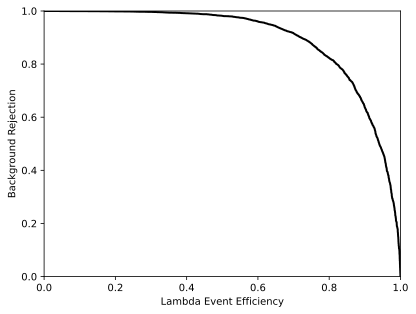

In [52]:
verbose = True
# Get ROC curve
test_Y = testing_data_MC.labels
# test_Y_normalized = transformed_latent_MC_obj.labels
# test_Y_normalized = transformed_latent_MC_obj.labels
# pfn_fp, pfn_tp, threshs = roc_curve(test_Y.detach().to("cpu").numpy(), probs_Y[:,1].detach().numpy())
pfn_fp, pfn_tp, threshs = roc_curve(test_Y.detach().to("cpu").numpy(), probs_Y[:,1].detach().numpy())

# Get area under the ROC curve

# auc = roc_auc_score(np.squeeze(test_Y.detach().to("cpu").numpy()), probs_Y[:,1].detach().numpy())
auc = roc_auc_score(np.squeeze(test_Y.detach().to("cpu").numpy()), probs_Y[:,1].detach().numpy())
if verbose: print(f'AUC = {auc:.4f}')
# if verbose: print(f'test_acc = {test_acc:.4f}')#DEBUGGING ADDED

# Create matplotlib plots for ROC curve and testing decisions
f = plt.figure()

# Get some nicer plot settings 
# plt.rcParams['figure.figsize'] = (4,4)#DEBUGGING
# f.rcParams['font.family'] = 'serif'
# f.rcParams['figure.autolayout'] = True

# Plot the ROC curve
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black')

# axes labels
plt.xlabel('Lambda Event Efficiency')
plt.ylabel('Background Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
# plt.legend([model.name+f": AUC={auc:.4f} acc={test_acc:.4f}"],loc='lower left', frameon=False)
f.show()
# f.savefig(os.path.join(log_dir,model.name+"_ROC_"+datetime.datetime.now().strftime("%F")+".png"))
# f.savefig("plots/paper_plots/roc_curves/MC_Aug_14.jpeg")

Here we can plot the classifier output

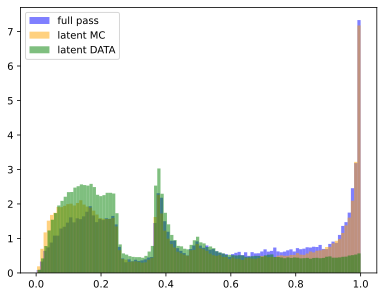

In [53]:
fig, ax = plt.subplots(1,1)
ax.hist(probs_DATA_test[:,1].detach().to("cpu"),color = "blue", alpha = 0.5, bins = 100,density = True, label = "full pass");
ax.hist(probs_MC[:,1].detach().to("cpu"), color = "orange", alpha = 0.5, bins = 100,density = True, label = "latent MC");
ax.hist(probs_DATA[:,1].detach().to("cpu"), color = "green", alpha = 0.5, bins = 100,density = True, label = "latent DATA");
ax.legend()
fig.show()
# fig.savefig("plots/paper_plots/output_distributions/August_14_three.jpeg",dpi = 200)

Below we can place a cut on the classifier output to view the signal and bg fits

roc_cut = 0.1 | FOM: 131.40627951887282 | purity: 0.7647141094742137


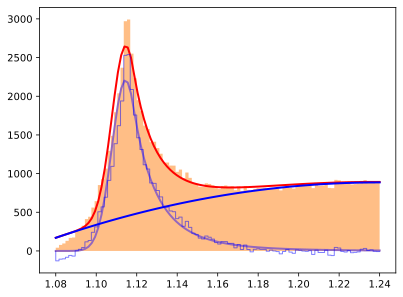

In [54]:
cut_hist = torch.empty(15,3)
roc_cut = 0.1
probs_data = probs_MC
# probs_data = probs_DATA_fp
# probs_data = probs_DATA
#     if(i > 3):
#         continue
if(roc_cut == 0):
    argmax_Y = torch.max(probs_data, 1)[1]
else:
    argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)

masked_mass = argmax_Y * training_data_MC.mass
# masked_mass = argmax_Y * training_data_DATA.mass
#     signal_mass = argmax_Y * testing_data_DATA.mass
signal_mass = np.array([])
for j in range(masked_mass.size()[0]):
    if(masked_mass[j] != 0):
        signal_mass = np.append(signal_mass, masked_mass[j])
# Define fit function


low_high = (1.08,1.24)
bins = 100

# hdata = np.histogram(signal_mass, range=low_high, bins=bins, density=False);
hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.average(hdata[0][-10:-1]), 37, 1.24
d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

def func(x, N, beta, m, loc, scale, B, A=A, C=C):
    return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

def sig(x, N, beta, m, loc, scale):
    return N*crystalball.pdf(-x, beta, m, -loc, scale)

def bg(x, B, A=A, C=C):
    return A*(1 - B*(x - C)**2)

optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))

x = np.linspace(low_high[0],low_high[1],bins)
y = hdata[0]

plt.plot(x, func(x, *optParams), color='r')
plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
plt.plot(x, bg(x, *optParams[5:]), color='b')

# bghist = np.histogram(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high);
bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b');
# plt.savefig("plots/bghist_0_07_diff.jpeg")

r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
chi2 = np.sum(np.square(r))
chi2ndf = chi2/len(optParams)

# Get S and N before and after? #DEBUGGING: ADDED
import scipy.integrate as integrate
mu      = optParams[3]
sigma   = optParams[4]
mmin    = mu - 2*sigma
mmax    = mu + 2*sigma


binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

bin1 = int((mmin-low_high[0])/binwidth)
bin2 = int((mmax-low_high[0])/binwidth)

integral_bghist = sum(bghist[0][bin1:bin2])

integral_tothist = sum(hdata[0][bin1:bin2])
try:
    fom = integral_bghist/np.sqrt(integral_tothist)
    purity =(integral_bghist)/integral_tothist
except Exception as inst:
     print(f"Caught {inst} | skipping cut #{i} = {roc_cut}")
print(f"roc_cut = {roc_cut} | FOM: {fom} | purity: {purity}")
# plt.savefig("plots/paper_plots/mass_fit/MC_August_14_avg.jpeg")

Now we can calculate the purity and figure of merit as functions of the cut output

To do this we cut the classifier at each cut value and fit the resulting mass spectrums with signal and bg functions, then integrate over the bins contained in these functions to estimate the number of signal and bg events

In [58]:
num_points = 20
fp_cut_hist = torch.zeros(num_points,3)

for i in range(num_points):
    roc_cut = i/num_points
#     probs_data = probs_MC
    probs_data = probs_DATA_fp
#     probs_data = probs_DATA_test
#     probs_data = probs_DATA
    #     if(i > 3):
    #         continue
#     if(roc_cut == 0):
#         argmax_Y = torch.max(probs_data, 1)[1]
#     else:
#         argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)
    argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)
#     masked_mass = argmax_Y * training_data_MC.mass
    masked_mass = argmax_Y * training_data_DATA.mass
#     signal_mass = argmax_Y * testing_data_DATA.mass
    signal_mass = np.array([])
    for j in range(masked_mass.size()[0]):
        if(masked_mass[j] != 0):
            signal_mass = np.append(signal_mass, masked_mass[j])
    # Define fit function


    low_high = (1.08,1.24)
    bins = 100

    hdata = np.histogram(signal_mass, range=low_high, bins=bins, density=False);
#     hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

    N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.average(hdata[0][-10:-1]), 37, 1.24
    d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
    parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
    parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

    def func(x, N, beta, m, loc, scale, B, A=A, C=C):
        return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

    def sig(x, N, beta, m, loc, scale):
        return N*crystalball.pdf(-x, beta, m, -loc, scale)

    def bg(x, B, A=A, C=C):
        return A*(1 - B*(x - C)**2)
    try:
        optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))
    except Exception as E:
        print(f"Exception caught: {E}; skipping cut: {roc_cut}")
        continue

    x = np.linspace(low_high[0],low_high[1],bins)
    y = hdata[0]

#     plt.plot(x, func(x, *optParams), color='r')
#     plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
#     plt.plot(x, bg(x, *optParams[5:]), color='b')

    bghist = np.histogram(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high);
#     bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b');
    # plt.savefig("plots/bghist_0_07_diff.jpeg")

    r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
    chi2 = np.sum(np.square(r))
    chi2ndf = chi2/len(optParams)

    # Get S and N before and after? #DEBUGGING: ADDED
    import scipy.integrate as integrate
    mu      = optParams[3]
    sigma   = optParams[4]
    mmin    = mu - 2*sigma
    mmax    = mu + 2*sigma


    binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

    bin1 = int((mmin-low_high[0])/binwidth)
    bin2 = int((mmax-low_high[0])/binwidth)

    integral_bghist = sum(bghist[0][bin1:bin2])

    integral_tothist = sum(hdata[0][bin1:bin2])
    try:
        fom = integral_bghist/np.sqrt(integral_tothist)
        purity =(integral_bghist)/integral_tothist
        fp_cut_hist[i] = torch.tensor([roc_cut, fom, purity])
    except Exception as inst:
        print(f"Caught {inst} | skipping cut #{i} = {roc_cut}")
        
#     print(f"roc_cut = {roc_cut} | FOM: {fom} | purity: {purity}")


In [56]:
num_points = 20
data_cut_hist = torch.zeros(num_points,3)

for i in range(num_points):
    roc_cut = i/num_points
#     probs_data = probs_MC
#     probs_data = probs_DATA_fp
    probs_data = probs_DATA
    #     if(i > 3):
    #         continue
#     if(roc_cut == 0):
#         argmax_Y = torch.max(probs_data, 1)[1]
#     else:
#         argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)
    argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)
#     masked_mass = argmax_Y * training_data_MC.mass
    masked_mass = argmax_Y * training_data_DATA.mass
    #     signal_mass = argmax_Y * testing_data_DATA.mass
    signal_mass = np.array([])
    for j in range(masked_mass.size()[0]):
        if(masked_mass[j] != 0):
            signal_mass = np.append(signal_mass, masked_mass[j])
    # Define fit function


    low_high = (1.08,1.24)
    bins = 100

    hdata = np.histogram(signal_mass, range=low_high, bins=bins, density=False);
#     hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

    N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.average(hdata[0][-10:-1]), 37, 1.24
    d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
    parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
    parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

    def func(x, N, beta, m, loc, scale, B, A=A, C=C):
        return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

    def sig(x, N, beta, m, loc, scale):
        return N*crystalball.pdf(-x, beta, m, -loc, scale)

    def bg(x, B, A=A, C=C):
        return A*(1 - B*(x - C)**2)
    try:
        optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))
    except Exception as E:
        print(f"Exception caught: {E}; skipping cut: {roc_cut}")
        continue

    x = np.linspace(low_high[0],low_high[1],bins)
    y = hdata[0]

#     plt.plot(x, func(x, *optParams), color='r')
#     plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
#     plt.plot(x, bg(x, *optParams[5:]), color='b')

    bghist = np.histogram(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high);
#     bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b');
    # plt.savefig("plots/bghist_0_07_diff.jpeg")

    r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
    chi2 = np.sum(np.square(r))
    chi2ndf = chi2/len(optParams)

    # Get S and N before and after? #DEBUGGING: ADDED
    import scipy.integrate as integrate
    mu      = optParams[3]
    sigma   = optParams[4]
    mmin    = mu - 2*sigma
    mmax    = mu + 2*sigma


    binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

    bin1 = int((mmin-low_high[0])/binwidth)
    bin2 = int((mmax-low_high[0])/binwidth)

    integral_bghist = sum(bghist[0][bin1:bin2])

    integral_tothist = sum(hdata[0][bin1:bin2])
    try:
        fom = integral_bghist/np.sqrt(integral_tothist)
        purity =(integral_bghist)/integral_tothist
        data_cut_hist[i] = torch.tensor([roc_cut, fom, purity])
    except Exception as inst:
        print(f"Caught {inst} | skipping cut #{i} = {roc_cut}")
        
#     print(f"roc_cut = {roc_cut} | FOM: {fom} | purity: {purity}")


Now we plot the FOM and purity as functions of the cut

You can save the plot via the final line using the *savefig()* function

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('cut')
ax1.scatter(fp_cut_hist[:,0], fp_cut_hist[:,1], label = "Transformed", color = "tab:red",marker = 'o', s = 15)
ax1.set_ylabel('FOM', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 50])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('purity', color=color)  # we already handled the x-label with ax1
ax2.scatter(fp_cut_hist[:,0], fp_cut_hist[:,2], color = "tab:red",marker = 'd',s = 15)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])
fig.legend()
# fig.text(0.6,0.2,"DATA")
fig.text(0.6,0.15,f"{len(training_data_DATA.mass)} events")
ax3=ax1.twinx()
ax3=ax1.twiny()
color = 'tab:orange'
# ax3.set_xlabel('cut')
ax3.scatter(data_cut_hist[:,0], data_cut_hist[:,1], label = "Data", color = "tab:blue",marker = 'o', s = 15)
# ax3.set_ylabel('Transformed FOM', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim([0, 50])
ax4 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
# ax4.set_ylabel('Transformed purity', color=color)  # we already handled the x-label with ax1
ax4.scatter(data_cut_hist[:,0], data_cut_hist[:,2], color = "tab:blue",marker = 'd',s = 15)
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ylim([0, 1])
fig.legend()
# fig.text(0.6,0.2,"DATA")
fig.text(0.6,0.15,f"{len(training_data_DATA.mass)} events")
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# fig.savefig("plots/paper_plots/FOMpure/double/Sept_1_average_20.jpeg")